I am trying the plotting function, along with edf reading and AOI defining functions on sample edf files from 2 studies. The first is an adult study run on EyeLink with PsychoPy. The second is an infant study, run with 6-month-old infants with EyeLink Experiment Builder. In both studies, participants view images presented on horizontally on the left, middle, and right side of the screen during the trials.

**Read and parse EDF**

In [27]:
import os
import eyelinkio
import numpy as np
import matplotlib.pyplot as plt
import numbers
import pandas as pd

#Load data
edf_path = '/Users/baharsener/visualEyes/data/edf/TG_2015.edf'

#Read edf
edf = eyelinkio.read_edf(edf_path)
print(edf)
edf.keys()

#Get screen coordinates
screen_coordinates = edf['info']['screen_coords']
print(screen_coordinates)

#Convert edf to pandas df
df = edf.to_pandas()
print(type(df['samples'])) #ndarray, look into this, fix it
print(df['samples'].head())
#df = edf['samples'].to_pandas() #(this is from Brenda's notebook)
#doing this instead for now:
samples = edf['samples']
df = pd.DataFrame(edf['samples'].T, columns=['xpos', 'ypos', 'pupil_area'])

loadEvents = 1
setTrial End:  END
loadEvents = 1
<EDF | TG_2015.edf> 
  Version: EYELINK II 1 
  Eye: LEFT_EYE 
  Pupil unit: PUPIL_AREA 
  Sampling frequency: 500.0 Hz 
  Calibrations: 0 
  Length: 1339.626 seconds 

[1280 1024]
<class 'pandas.core.frame.DataFrame'>
         xpos        ypos     ps
0  599.200012  452.500000  510.0
1  599.500000  454.200012  511.0
2  600.000000  455.899994  511.0
3  600.400024  457.299988  512.0
4  600.700012  459.100006  513.0


**AOI function**

In [28]:
def define_aoi(screen_width, screen_height, aoi_definitions):
    """
    Define Areas of Interest (AOIs).
    """
    if not isinstance(screen_width, numbers.Integral) or not isinstance(screen_height, numbers.Integral):
        raise ValueError("Screen dimensions must be integers.")
    if screen_width <= 0 or screen_height <= 0:
        raise ValueError("Screen dimensions must be positive.")
    if not isinstance(aoi_definitions, list):
        raise ValueError("AOI definitions must be a list of dictionaries.")
    
    mask = np.zeros((screen_height, screen_width), dtype=np.uint8)

    for aoi in aoi_definitions:
        shape = aoi['shape'].lower()
        coordinates = aoi['coordinates']
        
        if shape == 'rectangle':
            x1, y1, x2, y2 = map(int, coordinates)
            mask[y1:y2, x1:x2] = 1
        elif shape == 'circle':
            x_center, y_center, radius = map(int, coordinates)
            for y in range(screen_height):
                for x in range(screen_width):
                    if (x - x_center)**2 + (y - y_center)**2 <= radius**2:
                        mask[y, x] = 1
        else:
            raise ValueError(f"Unsupported AOI shape: {shape}")
    
    return mask


**Gaze plotting with heatmap and AOI**

In [29]:
def plot_heatmap_with_aoi(data, screen_coords, aoi_definitions=None, bins=None):
    """
    Plots a heatmap of eye-tracking data and overlays AOIs if defined.

    Parameters:
    - data: DataFrame containing 'xpos' and 'ypos' for plotting.
    - screen_coords: Tuple of (screen_width, screen_height,).
    - aoi_definitions: List of dictionaries defining the AOIs (optional).
    - bins: Either an integer specifying the number of bins for both dimensions,
            or a tuple (bins_x, bins_y) for separate bin sizes.
    """
    # Filter NaN values in the gaze columns
    data = data.dropna(subset=['xpos', 'ypos'])

    # Get screen width and height
    screen_width, screen_height = screen_coords

    # Filter gaze data outside the screen coordinates
    data = data[(data['xpos'] >= 0) & (data['xpos'] <= screen_width) & 
            (data['ypos'] >= 0) & (data['ypos'] <= screen_height)]

    # Determine bins (depends a bit on screen)
    if bins is None:  # Default bins, 20 px bins here if nothing else is given
        bins_x = int(screen_width / 20)
        bins_y = int(screen_height / 20)
    elif isinstance(bins, int):  # User-defined, if bins for x and y are the same
        bins_x = bins_y = bins
    elif isinstance(bins, (tuple, list)) and len(bins) == 2:  # User-defined, if different bins for x and y are desired
        bins_x, bins_y = bins
    else:
        raise ValueError("`bins` must be an integer or a tuple of two integers.")

    heatmap, xedges, yedges = np.histogram2d(
    data['xpos'], data['ypos'], bins=[bins_x, bins_y]
)

    # Plot the heatmap without transposing
    plt.imshow(heatmap.T, origin='lower', cmap='viridis', extent=[0, screen_width, 0, screen_height])
    plt.colorbar(label='Count')

    # Adjust x and y axis limits
    plt.xlim(0, screen_width)
    plt.ylim(0, screen_height)

    # If AOIs are defined, overlay them
    if aoi_definitions:
        aoi_mask = define_aoi(screen_width, screen_height, aoi_definitions)
        plt.imshow(aoi_mask.T, origin='lower', alpha=0.3, cmap='Reds')  # Overlay AOI in semi-transparent red

    # Add title and display the plot
    plt.title('Heatmap of Gaze Data')
    plt.xlabel('X Position (pixels)')
    plt.ylabel('Y Position (pixels)')
    plt.show()

**Plot adult data with the AOI as the fixation cross presented in the middle**

loadEvents = 1
setTrial End:  END
loadEvents = 1
[1280 1024]
<class 'pandas.core.frame.DataFrame'>
         xpos        ypos     ps
0  599.200012  452.500000  510.0
1  599.500000  454.200012  511.0
2  600.000000  455.899994  511.0
3  600.400024  457.299988  512.0
4  600.700012  459.100006  513.0


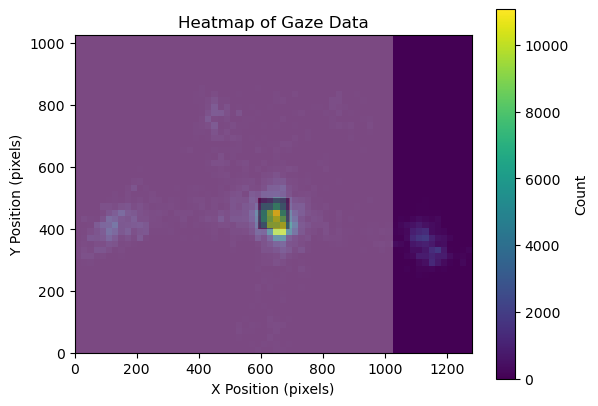

In [30]:
#Clear previous
plt.clf()
plt.close()

#Load data
edf_path = '/Users/baharsener/visualEyes/data/edf/TG_2015.edf'

#Read edf
edf = eyelinkio.read_edf(edf_path)
edf.keys()

#Get screen coordinates
screen_coordinates = edf['info']['screen_coords']
print(screen_coordinates)

#Convert edf to pandas df
df = edf.to_pandas()
print(type(df['samples'])) 
print(df['samples'].head())
#df = edf['samples'].to_pandas() #(this is from Brenda's notebook)
#doing this instead for now:
samples = edf['samples']
df = pd.DataFrame(edf['samples'].T, columns=['xpos', 'ypos', 'pupil_area'])

#Define an AOI
screen_width, screen_height = screen_coordinates
aoi_definitions = [{'shape': 'rectangle', 'coordinates': (400, 590, 500, 691)}]

#Gaze data (just x and y)
data = df.dropna(subset=['xpos', 'ypos'])

#Plot
plot_heatmap_with_aoi(data, screen_coordinates, aoi_definitions)

**Now with infant data, without an AOI (infants are not presented with a fixation cross because we cannot instruct them to look at it)**

loadEvents = 1
Missing 1 samples. Inserting dummy samples 
Missing (3337940-3337943) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3338072-3338075) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3340772-3340775) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3340936-3340939) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3341018-3341021) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3352784-3352787) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3352826-3352829) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3352914-3352917) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3360700-3360703) samples. Calculating speriod 
Missing 1 samples. Inserting dummy samples 
Missing (3361278-3361281) samples. Calcul

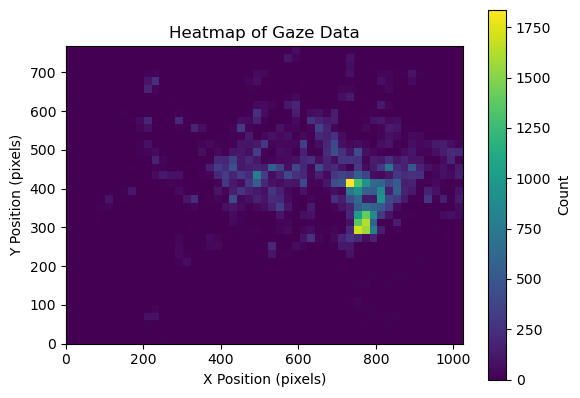

In [31]:
#Clear previous
plt.clf()
plt.close()

#Load data
edf_path = '/Users/baharsener/Desktop/BMG_1122.edf'

#Read edf
edf = eyelinkio.read_edf(edf_path)
edf.keys()

#Get screen coordinates
screen_coordinates = edf['info']['screen_coords']
print(screen_coordinates)

#Convert edf to pandas df
df = edf.to_pandas()
print(type(df['samples'])) 
print(df['samples'].head())
samples = edf['samples']
df = pd.DataFrame(edf['samples'].T, columns=['xpos', 'ypos', 'pupil_area'])

#Gaze data (just x and y)
data = df.dropna(subset=['xpos', 'ypos'])

#Plot
aoi_definitions = None
plot_heatmap_with_aoi(data, screen_coordinates, aoi_definitions)

You can see here how different adult and infant eye data can look! Adults were explicitly instructed to look to the fixation cross in the middle (where the AOI overlay is) and also instructed to look at the images, so we see the three clear locations in which the images appeared. This plot could tell us whether the participant is following instructions, and whether our calibration was good! With the infants, it is trickier, because we cannot explicitly instruct them. However, I can see that this infant was not reliably looking at all three images presented, and mostly only fixated on the right side of the screen, potentially due to one particular image being interesting, or because there was one trial for which they were more attentive. Because the overall pattern looks odd, I will do a deeper dive into understanding which trials this baby was attending to the screen.